In [1]:
import json
import spotipy
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
import re
from key_file import *

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

user = sp.user(user_name)
print(user)


{'display_name': 'efeertugrul', 'external_urls': {'spotify': 'https://open.spotify.com/user/efeertugrul'}, 'followers': {'href': None, 'total': 47}, 'href': 'https://api.spotify.com/v1/users/efeertugrul', 'id': 'efeertugrul', 'images': [{'height': None, 'url': 'https://i.scdn.co/image/ab6775700000ee855be5f1690e1a5d5624995f67', 'width': None}], 'type': 'user', 'uri': 'spotify:user:efeertugrul'}


In [38]:
def find_min_sum_n(x):    
    def factors(x):
        factors= []
        for i in range(1, x + 1):
            if x % i == 0:
                factors.append(i)
        return factors
    factor_list = factors(x)
    length = len(factor_list)
    if length%2==0:
        n = int(length/2)
        return factor_list[n], factor_list[n-1]
    else:
        from math import isqrt
        n = int(isqrt(x))
        return n, n
print(find_min_sum_n(50))

(10, 5)


In [86]:
from math import pi
def plot_radar(playlist_dfs:[{str,pd.DataFrame}], columns:[str], is_multiple=True):
    N = len(columns)
    value_list = []
    angles = [n/float(N)*2*pi for n in range(N)]
    angles += angles[:1]
    
    n_df = len(playlist_dfs)
    n_row, n_column = find_min_sum_n(n_df)
    
    plt.rcParams['figure.facecolor'] = 'white'
    
    figure, axis = plt.subplots(n_row, n_column, figsize=(n_row**3-n_row**2, n_column**3-n_column**2, ), subplot_kw={'projection': 'polar'})
    for ax in axis:
        for ay in ax:
            ay.set_axis_off()
    x, y = 0, 0
    for dct in playlist_dfs:
        df = dct['df']
        title = dct['title']
        val = list(df.mean())
        val += val[:1]
        axis[x,y].plot(angles, val)
        axis[x,y].fill(angles,val,alpha=0.3)
        axis[x,y].set_xticks(angles[:-1],categories, size=n_row**2-n_row)
        axis[x,y].set_yticks(axis[x,y].get_yticks(), color='grey',size=n_row**2-n_row)
        axis[x,y].set_axis_on()
        axis[x,y].set_title(title)
        y+=1
        if y == n_column:
            y = 0
            x += 1
    plt.show()



In [2]:
class Spotify_Tools:
    
    @staticmethod
    def user_to_playlist_uris(username):
        #returns users playlist uris
        playlists = sp.user_playlists(username)
        playlist_uris = []
        while playlists:
            for playlist in playlists['items']:
                x = re.search("(?<=spotify:playlist:)(.)*", playlist['uri'])
                playlist_uris.append(x.group(0))
            if playlists['next']:
                playlists = sp.next(playlists)
            else:
                playlists = None
        return playlist_uris

    @staticmethod
    def user_to_playlist_names(username):
        #returns user's playlist names
        playlists = sp.user_playlists(username)
        playlist_names = []
        while playlists:
            for playlist in playlists['items']:
                playlist_names.append(playlist['name'])
            if playlists['next']:
                playlists = sp.next(playlists)
            else:
                playlists = None
        return playlist_names
    
    @staticmethod
    def playlist_to_track_ids(playlist_uri):
        #returns track ids in a playlist
        response = sp.playlist_items(playlist_uri, 'items.track.id')
        track_list = [x['track']['id'] for x in response['items']]
        return track_list
    @staticmethod
    def track_feature(track_id):
        #returns track or tracks audio features 
        feature_dictionary = sp.audio_features(track_id)
        return feature_dictionary
    
    @classmethod
    def user_to_playlists(cls, username):
        #returns user's playlists as a list
        u_playlists = sp.user_playlists(username)
        playlists = []
        playlist_uri = ""
        while u_playlists:
            for playlist in u_playlists['items']:
                x = re.search("(?<=spotify:playlist:)(.)*", playlist['uri'])
                playlist_uri = x.group(0)
                name = playlist['name']
                playlists.append({"title": name, "song_ids": cls.playlist_to_track_ids(playlist_uri)})
            if u_playlists['next']:
                u_playlists = sp.next(u_playlists)
            else:
                u_playlists = None
        return playlists
    
    @staticmethod
    def track_artists(track_id):
        #returns artists
        meta = sp.track(track_id)
        s = ', '
        artist=s.join([singer_name['name'] for singer_name in meta['artists']])
        return artist
    @staticmethod
    def track_popularity(track_id):
        #returns popularity
        meta = sp.track(track_id)
        return meta["popularity"]
    @staticmethod
    def track_n_a_p(track_id):
        #returns name, artists, and popularity as a tuple
        meta = sp.track(track_id)
        s = ', '
        artist=s.join([singer_name['name'] for singer_name in meta['artists']])
        return meta["name"], artist, meta["popularity"]
    @classmethod
    def generate_track_df(cls, playlists):
        """
            playlists: {'title': str,'song_ids': List[str]}
        """
        all_song_features = []
        for playlist in playlists:
            song_features = cls.track_feature(playlist['song_ids'])
            for song_feature in song_features:
                name, artist, popularity = Spotify_Tools.track_n_a_p(song_feature['id'])
                song_feature.update({'playlist': playlist['title'], 'name': name, 'artist': artist, 'popularity': popularity})
                del name, artist, popularity
            all_song_features += song_features
        return pd.DataFrame(all_song_features)

In [3]:
#import from the file if exists for convenience while developing
from os.path import exists
path = './Spotify Data.csv'
file_exists = exists(path)
if file_exists:
    df = pd.read_csv(path, index_col=0)
else:
    playlists = Spotify_Tools.user_to_playlists(user_name)
    df = Spotify_Tools.generate_track_df(playlists)

#create and add minimum and maximum values of the numeric columns for min max scaling
min_datum = {'acousticness':0, 'danceability':0, 'energy': 0,
             'instrumentalness': 0, 'key':-1, 'liveness':0,
            'loudness': -60, 'mode':0, 'speechiness': 0, 
            'tempo': 0, 'time_signature': 3, 'valence': 0,
            'popularity': 0}
max_datum = {'acousticness':1, 'danceability':1, 'energy': 1,
             'instrumentalness': 1, 'key':11, 'liveness':1,
            'loudness': 0, 'mode':1, 'speechiness': 1, 
            'tempo': 1015, 'time_signature': 7, 'valence': 1,
            'popularity': 100}
min_max_data = [min_datum, max_datum]
df = pd.concat([pd.DataFrame(min_max_data), df])
#column names of the numeric values
music_features = ['danceability', 'energy', 'key', 'loudness', 'mode',
                  'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence', 'tempo',
                  'time_signature', 'popularity']

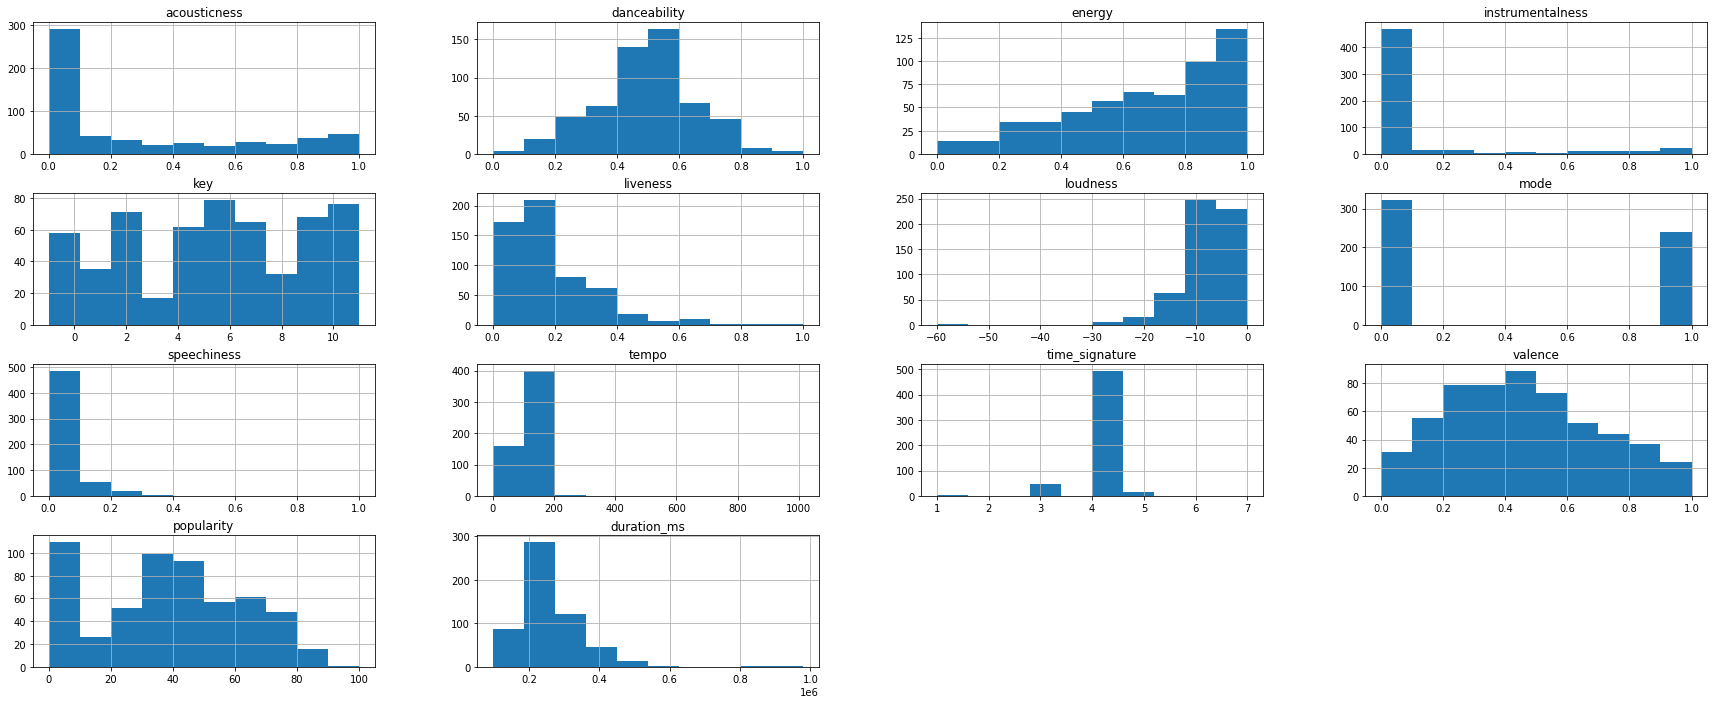

In [5]:
df.hist(layout=(5,4), figsize=(30,15))
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[music_features])
scaled_df = pd.DataFrame(columns=music_features, data = scaled)

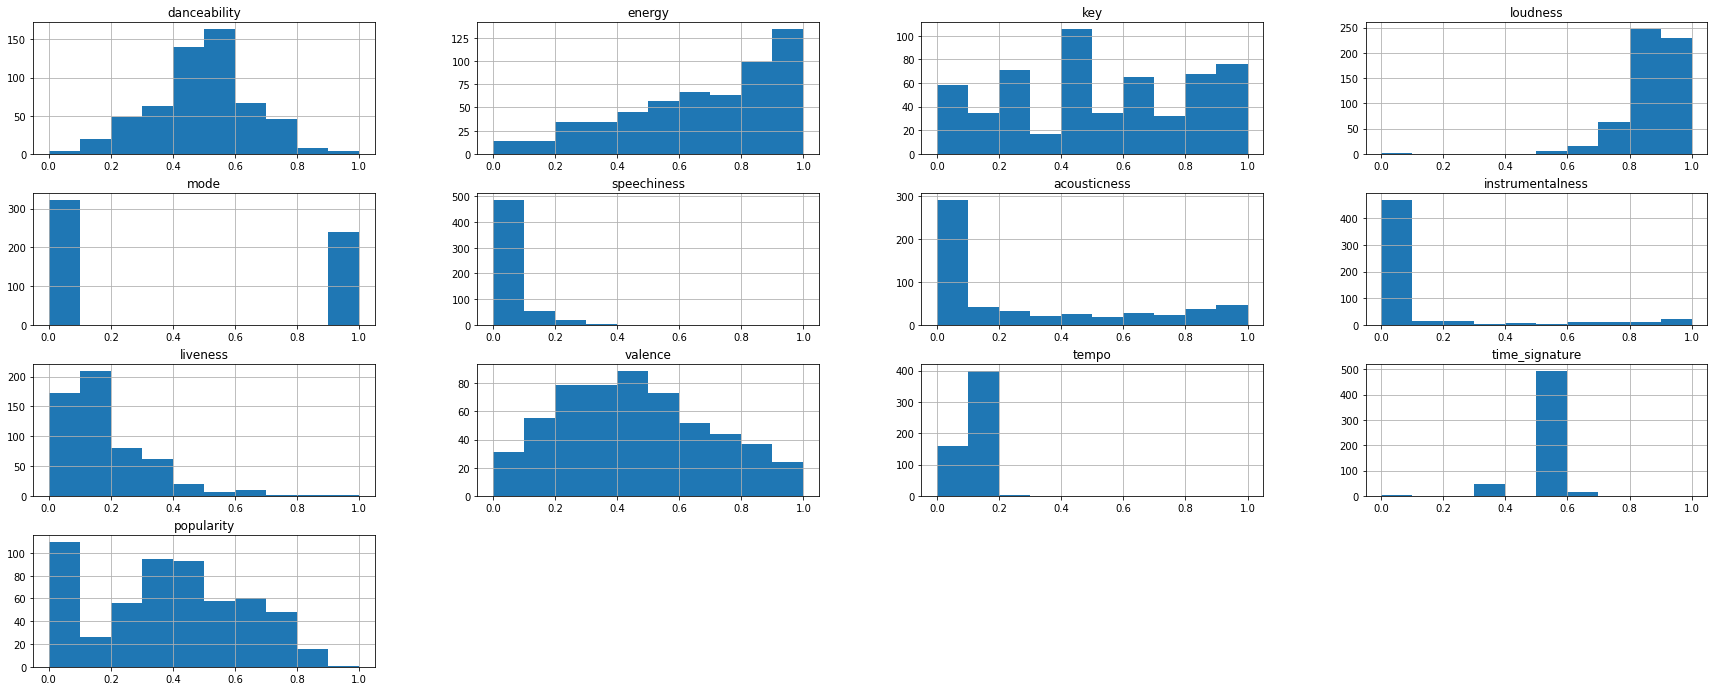

In [9]:
scaled_df.hist(layout=(5,4), figsize=(30,15))
plt.show()

In [78]:
playlist_titles = df['playlist'].dropna().unique()

playlist_dfs = []
for title in playlist_titles:
    scaled_i = scaler.transform(df.loc[df['playlist']== title][music_features])
    
    playlist_dfs.append({'title':title, 'df':pd.DataFrame(scaled_i, columns=music_features)})

In [87]:
plot_radar(playlist_dfs, music_features)

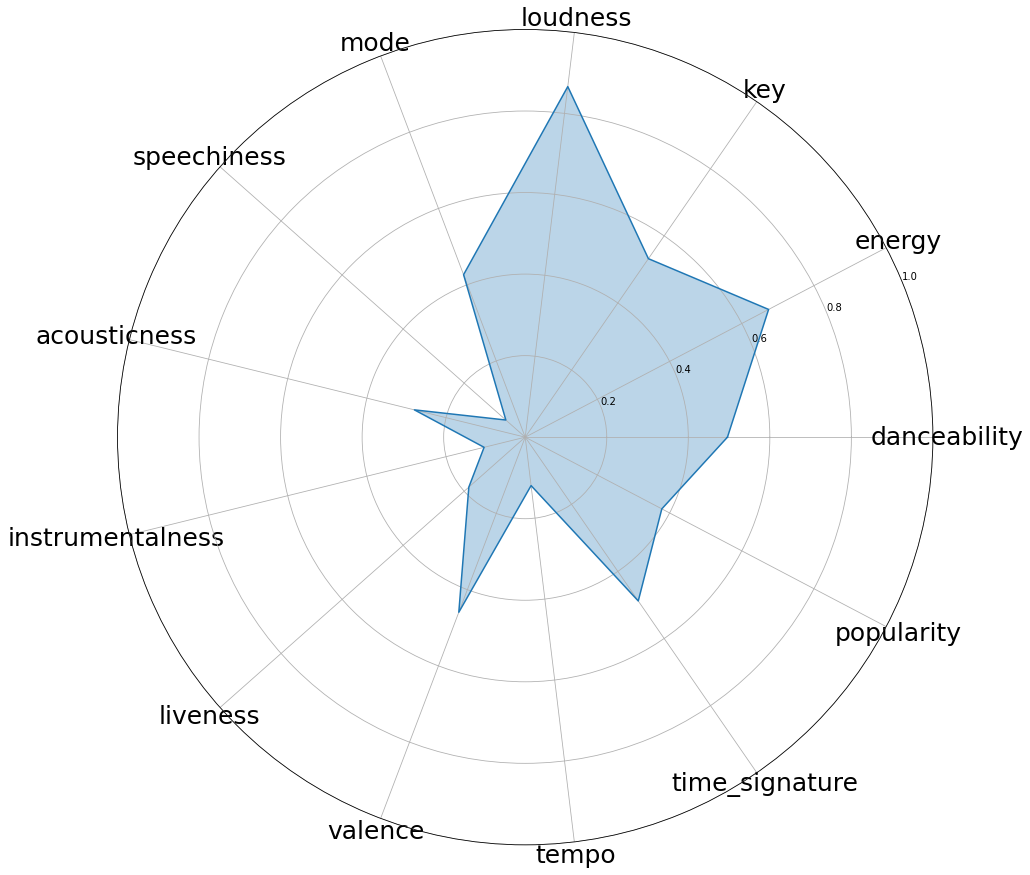

In [14]:
n_edge=1
# plot size
# convert column names into a list
categories=list(scaled_df.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value=list(scaled_df.mean())

# repeat first value to close the circle
# the plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
value+=value[:1]
# calculate angle for each category
angles=[n/float(N)*2*pi for n in range(N)]
angles+=angles[:1]

# plot
if n_edge>1:
    
    figure, axis = plt.subplots(n_edge, n_edge, figsize=(n_edge**2, n_edge**2, ), subplot_kw={'projection': 'polar'})

    axis[0,0].plot(angles, value)
    axis[0,0].fill(angles,value,alpha=0.3)
    axis[0,0].set_xticks(angles[:-1],categories, size=7)
    axis[0,0].set_yticks(axis[0,0].get_yticks(), color='grey',size=7)
else:
    
    figure, axis = plt.subplots(n_edge, n_edge, figsize=(15, 15, ), subplot_kw={'projection': 'polar'})

    axis.plot(angles, value)
    axis.fill(angles,value,alpha=0.3)
    axis.set_xticks(angles[:-1],categories, size=25)
    axis.set_yticks(axis.get_yticks(), color='grey',size=7)
# plt.title('Discovery Weekly Songs Audio Features', size=35)

plt.show()